In [46]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [47]:
# Import torch
import torch
from torch import nn
import matplotlib.pyplot as plt

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup random seed
RANDOM_SEED = 42
device

'cpu'

## 1. Creating a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/)
  * Spliting the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors
  * Construct a model capable of fitting the data
  * Building a loss function and optimizer capable of handling multi-class data
  * Making a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy
  * Plot the decision boundaries on the spirals dataset from your model predictions

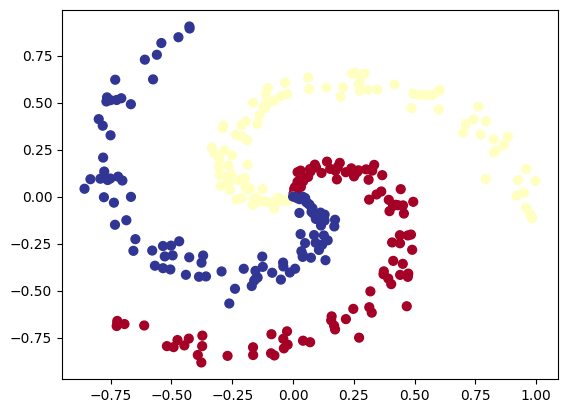

In [48]:
# Code for creating a spiral dataset from CS231n
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [49]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

len(X_train), len(y_train), len(X_test), len(y_test)

(240, 240, 60, 60)

In [50]:
# Calculate the accuracy for when we fit our model
!pip -q install torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [51]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear1 = nn.Linear(in_features=2,
                             out_features=10)
    self.linear2 = nn.Linear(in_features=10,
                             out_features=10)
    self.linear3 = nn.Linear(in_features=10,
                             out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))


# Instantiate model and send it to device
model_1 = SpiralModel().to(device)
model_1

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [52]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype)

# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
print(model_1(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_1(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_1(X_train)[:10], dim=1).argmax(dim=1))

torch.float32 torch.int64 torch.float32 torch.int64
Logits:
tensor([[-0.0575, -0.2314, -0.4162],
        [-0.0686, -0.2215, -0.4189],
        [-0.0454, -0.2190, -0.4150],
        [-0.0847, -0.1681, -0.3650],
        [-0.0774, -0.1684, -0.3741],
        [-0.0553, -0.1976, -0.4047],
        [-0.0504, -0.2049, -0.4085],
        [-0.0434, -0.2521, -0.4255],
        [-0.0664, -0.2029, -0.4171],
        [-0.0853, -0.1679, -0.3640]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3939, 0.3310, 0.2751],
        [0.3902, 0.3349, 0.2749],
        [0.3950, 0.3321, 0.2729],
        [0.3738, 0.3439, 0.2824],
        [0.3765, 0.3437, 0.2798],
        [0.3887, 0.3372, 0.2741],
        [0.3913, 0.3353, 0.2735],
        [0.4010, 0.3254, 0.2736],
        [0.3881, 0.3386, 0.2733],
        [0.3735, 0.3439, 0.2826]], grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [53]:
# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                            lr=0.02)

In [54]:
# Building a training loop for the model
epochs = 1000
# Loop over data
for epoch in range(epochs):

  ## Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():

    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)
  # Print out each 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.11 Acc: 0.32 | Test loss: 1.09 Test acc: 0.37
Epoch: 100 | Loss: 0.13 Acc: 0.96 | Test loss: 0.10 Test acc: 0.97
Epoch: 200 | Loss: 0.05 Acc: 0.99 | Test loss: 0.02 Test acc: 1.00
Epoch: 300 | Loss: 0.03 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 400 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 500 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 600 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 0.98
Epoch: 700 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 0.98
Epoch: 900 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 0.98


In [55]:
# Plot the model predictions
def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

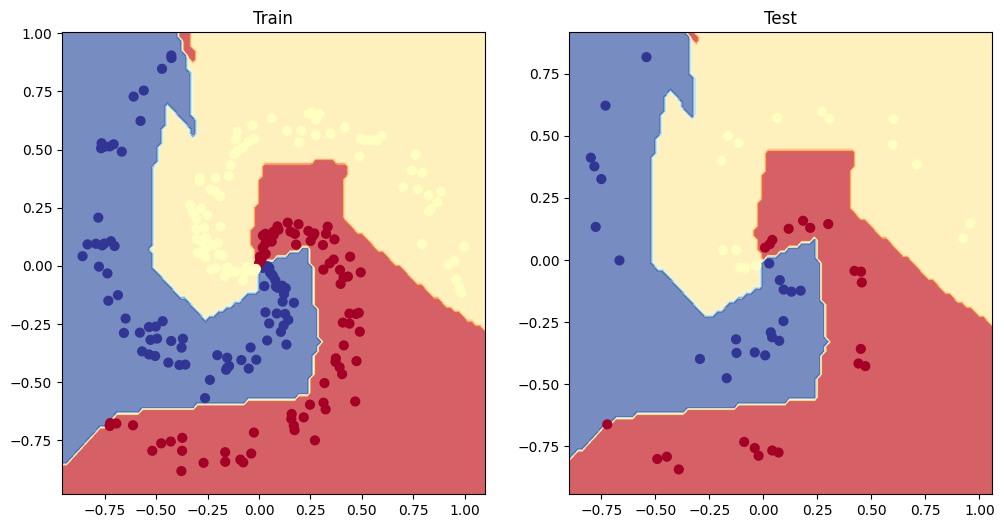

In [56]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)